In [367]:
import os
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np

import utils

In [368]:
%matplotlib inline

In [369]:
main_path = Path.cwd() / ".."

---

Cargamos las imagenes a usar en el ejercicio.

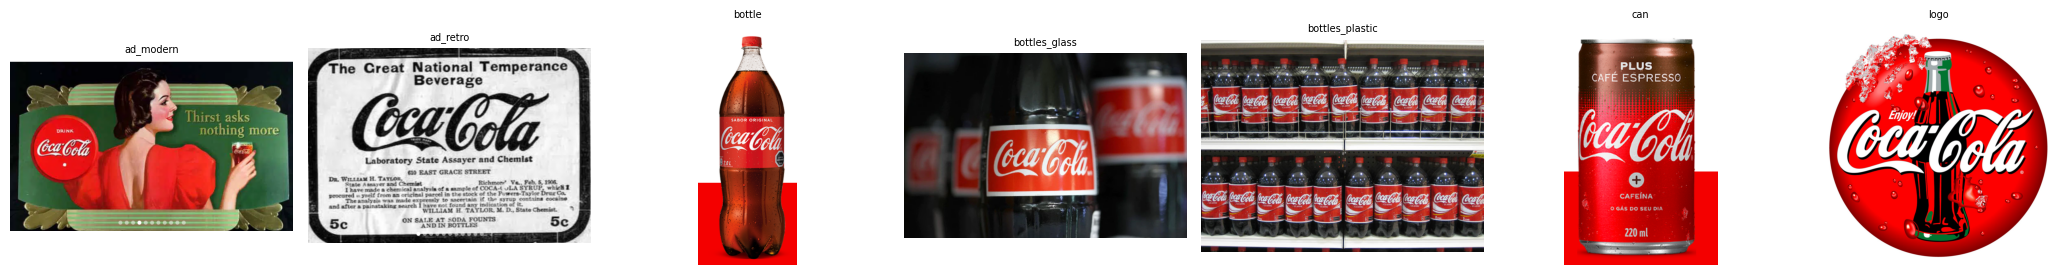

Images shape:

ad_modern:        h_429, w_715
ad_retro:         h_493, w_715
bottle:           h_500, w_207
bottles_glass:    h_450, w_687
bottles_plastic:  h_598, w_799
can:              h_363, w_233
logo:             h_1389, w_1389


In [370]:
folder_path = main_path / "data/images"

dict_imgs = {}
for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)

    name, _ = os.path.splitext(filename)
    dict_imgs[name] = cv2.imread(file_path)

utils.plot_imgs(list(dict_imgs.values()), list(dict_imgs.keys()), rows=1, figsize=3)

print("Images shape:\n")
for name, img in dict_imgs.items():
    blank = " "
    print(f"{name}:{blank*(16-len(name))} h_{img.shape[0]}, w_{img.shape[1]}")

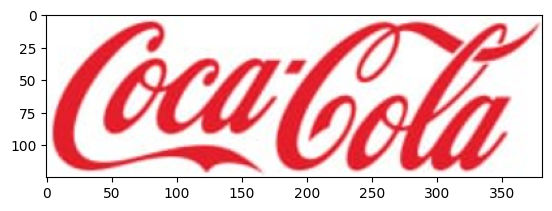

In [371]:
folder_path = main_path / "data/template"
filename = "logo_template.png"
file_path = os.path.join(folder_path, filename)

template = cv2.imread(file_path)

# Crop the template
template = template[27:152,7:388,:]
plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))

---

##### Ejercicio 1

Obtener una detección del logo en cada imagen sin falsos positivos.

Como podemos observar, los logos en las imagenes sobre las que vamos a buscar están en blanco sobre rojo o negro sobre blanco. Por lo cual un template con el logo en tono medio (rojo) sobre fondo blanco va a ser subóptimo para matchear.

Vamos a obtener los bordes de las imágenes y del template utilizando Canny. De esta manera vamos a poder matchear generalizando a nuevos casos en los que el logo aparezca sobre un fondo completamente diferente.

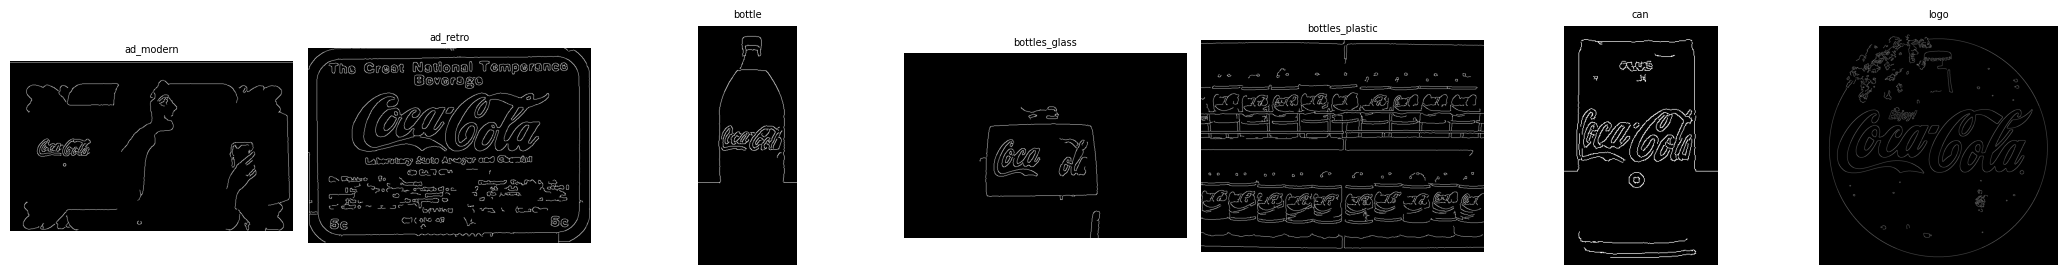

In [372]:
dict_imgs_border = {}
for name, img in dict_imgs.items():
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, ksize=(7, 7), sigmaX=3, sigmaY=3)
    # Obtain borders using Canny
    img_border = cv2.Canny(img_gray, threshold1=5, threshold2=210)

    dict_imgs_border[name] = img_border

utils.plot_imgs(list(dict_imgs_border.values()), list(dict_imgs_border.keys()), rows=1, figsize=3)

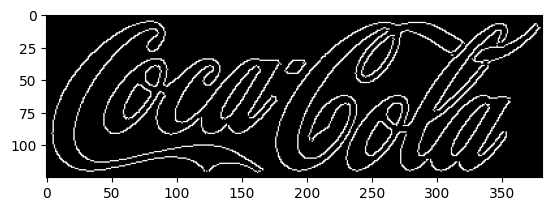

In [373]:
template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
# Gaussian blur to remove noise
template_gray = cv2.GaussianBlur(template_gray, ksize=(5, 5), sigmaX=3, sigmaY=3)
# Obtain borders using Canny
template_border = cv2.Canny(template_gray, threshold1=5, threshold2=200)

plt.imshow(cv2.cvtColor(template_border, cv2.COLOR_BGR2RGB))

Encontramos además logos de diversos tamaños en las imágenes sobre las que vamos a matchear. Por este motivo vamos a tener que generar templates de diversas escalas para poder matchearlos.

logo menor: h_35, w_75


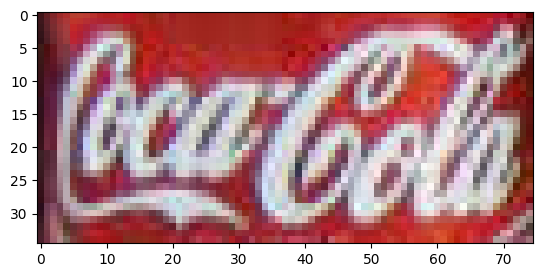

In [374]:
# Logo de menor encontrado en las imágenes
logo_menor = dict_imgs["bottles_plastic"][154:189,115:190,:]
print(f"logo menor: h_{logo_menor.shape[0]}, w_{logo_menor.shape[1]}")

plt.imshow(cv2.cvtColor(logo_menor, cv2.COLOR_BGR2RGB))

logo mayor: h_400, w_1155


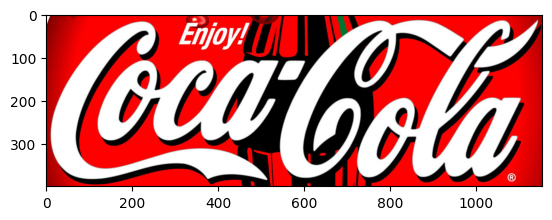

In [375]:
# Logo de mayor tamaño encontrado en las imágenes
logo_mayor = dict_imgs["logo"][470:870,95:1250,:]
print(f"logo mayor: h_{logo_mayor.shape[0]}, w_{logo_mayor.shape[1]}")

plt.imshow(cv2.cvtColor(logo_mayor, cv2.COLOR_BGR2RGB))

In [376]:
scales = np.linspace(0.3, 3, 26)
scales_x = [.7, .85, 1]

list_templates = []
for scale in scales:
    for scale_x in scales_x:
        list_templates.append(cv2.resize(template_border, None, fx=scale*scale_x, fy=scale))

---

In [387]:
methods = [
    "cv2.TM_CCOEFF",
    "cv2.TM_CCOEFF_NORMED",
    "cv2.TM_CCORR",
    "cv2.TM_CCORR_NORMED",
    "cv2.TM_SQDIFF",
    "cv2.TM_SQDIFF_NORMED",
]

meth = "cv2.TM_CCOEFF"
method = eval(meth)
current_image = "logo"

list_shape = []
list_loc = []
list_val = []
for template in list_templates:
    template_too_tall = template.shape[0] > dict_imgs_border[current_image].shape[0]
    template_too_wide = template.shape[1] > dict_imgs_border[current_image].shape[1]
    if (template_too_tall | template_too_wide):
        break

    res = cv2.matchTemplate(dict_imgs_border[current_image], template, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
        val = min_val
    else:
        top_left = max_loc
        val = max_val

    # Avg value per pixel to compare templates of different sizes
    if method not in [cv2.TM_CCOEFF_NORMED, cv2.TM_CCORR_NORMED, cv2.TM_SQDIFF_NORMED]:
        val = val / len(template.flatten())

    list_shape.append(template.shape[:2])
    list_loc.append(top_left)
    list_val.append(val)

In [388]:
# cv2 works with (x, y) | numpy works with (y, x)

list_annotated = []
for i, loc in enumerate(list_loc):
    img_salida = dict_imgs[current_image].copy()

    bottom_right = (loc[0] + list_shape[i][1], loc[1] + list_shape[i][0])
    cv2.rectangle(img_salida, loc, bottom_right, color=(0, 255, 0), thickness=5)

    list_annotated.append(img_salida)

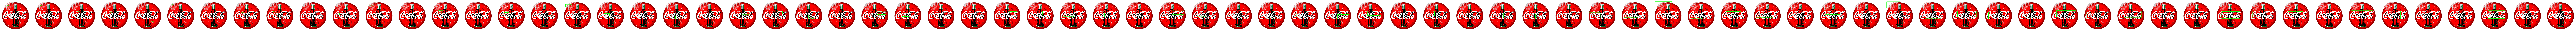

In [389]:
utils.plot_imgs(list_annotated, rows=1,  figsize=4)

In [390]:
list_val

[411.1284128289474,
 417.6809549647314,
 391.1726685133887,
 359.4614813815434,
 349.72890671420083,
 321.0147375079064,
 316.6986243206522,
 313.4909945733533,
 353.05575824873097,
 297.85285372258267,
 300.40743208936277,
 271.4935089420384,
 253.20479375696766,
 233.9109567051917,
 217.36335125448028,
 238.3092474489796,
 216.24807422969187,
 207.7500892857143,
 218.18597004019,
 206.77958284290915,
 188.58387066738052,
 216.68122716526972,
 231.0374579124579,
 175.3182948891904,
 199.0071586389748,
 198.84480941826243,
 159.33587927888928,
 190.36850893304393,
 170.40179825364842,
 157.88816702327694,
 188.6014545111837,
 156.82943450879984,
 165.68522385107366,
 170.09072072804096,
 156.11455405345112,
 140.00768049155147,
 169.05980046948358,
 163.44135396518377,
 141.5628947368421,
 161.77841202870675,
 137.0456895965163,
 147.63215347555285,
 150.4263642250618,
 148.42972179903788,
 156.39882525697504,
 144.130615234375,
 126.88656216505895,
 121.04303278688525,
 125.8079671649

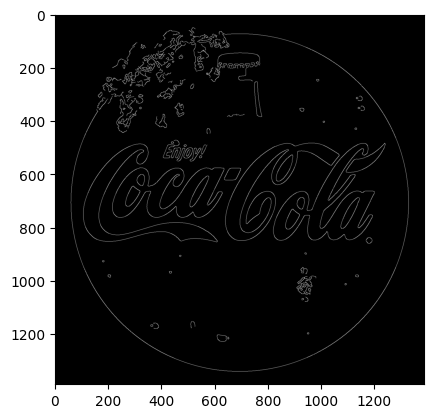

In [391]:
new_img = dict_imgs_border["logo"].copy()

plt.imshow(new_img, cmap="gray")